In [ ]:
#%conda install keras

In [1]:
import numpy as np
import pandas as pd 
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os

IMAGE_WIDTH=100
IMAGE_HEIGHT=100
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

filenames = os.listdir("./train")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})


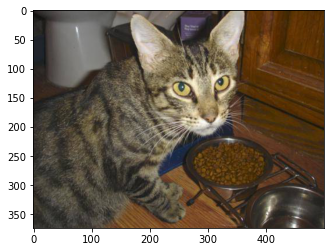

In [2]:
sample = random.choice(filenames)
image = load_img("./train/"+sample)
plt.imshow(image)

In [3]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(MaxPooling2D(2, 2))


model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 98, 98, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 47, 47, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 21, 21, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 10, 10, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 12800)             0

In [4]:
df["category"] = df["category"].replace({0: 'cat', 1: 'dog'}) 

In [5]:

from keras.callbacks import EarlyStopping, ReduceLROnPlateau


earlystop = EarlyStopping(patience=10)


learning_rate_reduction = ReduceLROnPlateau(monitor='accuracy', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.8, 
                                            min_lr=0.00001)





callbacks = [earlystop, learning_rate_reduction]


In [6]:
df_work,df_work2=train_test_split(df, test_size=0.8)

In [7]:
train_df, validate_df = train_test_split(df_work, test_size=0.25)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)


In [8]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

In [9]:

train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "./train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)


Found 3750 validated image filenames belonging to 2 classes.


In [10]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "./train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)


Found 1250 validated image filenames belonging to 2 classes.


In [11]:
validation_generator

In [12]:
epochs=1
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    callbacks=callbacks
)

/home/ml/miniconda3/envs/siemens/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


250/250 [==============================] - 322s 1s/step - loss: 0.7361 - accuracy: 0.4955


In [28]:
from tensorflow.keras.applications import inception_v3 as inc_net

In [62]:

#model.save_weights('./weight.h5')

In [16]:
test_df.iloc[12]['filename']

'8682.jpg'

In [ ]:
img

In [14]:
import skimage
from skimage import io,transform
from tensorflow.keras.preprocessing import image

test_filenames = os.listdir("./test1")
test_df = pd.DataFrame({
    'filename': test_filenames
})
#img = load_img("./test1/"+test_df.iloc[12]['filename'], target_size=IMAGE_SIZE)

img = skimage.io.imread("./test1/"+test_df.iloc[12]['filename'])
img = skimage.transform.resize(img, (100,100))
    
img = image.img_to_array(img)
img = np.expand_dims(img, axis=0)

preds = model.predict(img)
prediction = np.argmax(preds)
pct = np.max(preds)

if prediction == 0:
    print('It\'s a cat!')
else:
    print('It\'s a dog!')


print(pct)

It's a cat!
0.50247437


In [ ]:
#%pip install lime

In [17]:

from lime import lime_image

explainer = lime_image.LimeImageExplainer()

In [19]:

explanation = explainer.explain_instance(img[0].astype('double'), model.predict,  
                                         top_labels=3, hide_color=0, num_samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

(-0.5, 99.5, 99.5, -0.5)

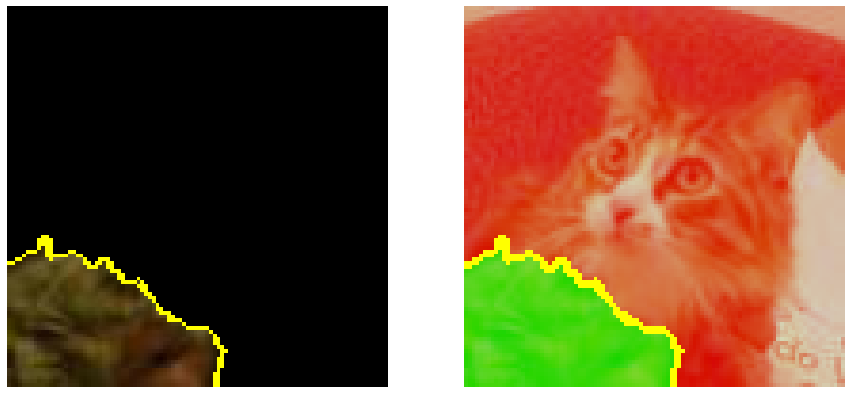

In [20]:

from skimage.segmentation import mark_boundaries

temp_1, mask_1 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
temp_2, mask_2 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))
ax1.imshow(mark_boundaries(temp_1, mask_1))
ax2.imshow(mark_boundaries(temp_2, mask_2))
ax1.axis('off')
ax2.axis('off')

In [21]:
from tensorflow.keras.applications.imagenet_utils import decode_predictions
from tensorflow.keras.applications import inception_v3 as inc_net


In [26]:

def transform_img_fn_ori():
    
    img = skimage.io.imread("./test1/"+test_df.iloc[12]['filename'])
    img = skimage.transform.resize(img, (299,299))
    img = (img - 0.5)*2
    img = np.expand_dims(img, axis=0)
    preds = inet_model.predict(img)
    for i in decode_predictions(preds)[0]:
        print(i)
    return img

inet_model = inc_net.InceptionV3()
images_inc_im = transform_img_fn_ori()

('n02123045', 'tabby', 0.6774001)
('n02123159', 'tiger_cat', 0.11954438)
('n02124075', 'Egyptian_cat', 0.10521146)
('n02971356', 'carton', 0.008235232)
('n02123394', 'Persian_cat', 0.008082116)


  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 298.5, 298.5, -0.5)

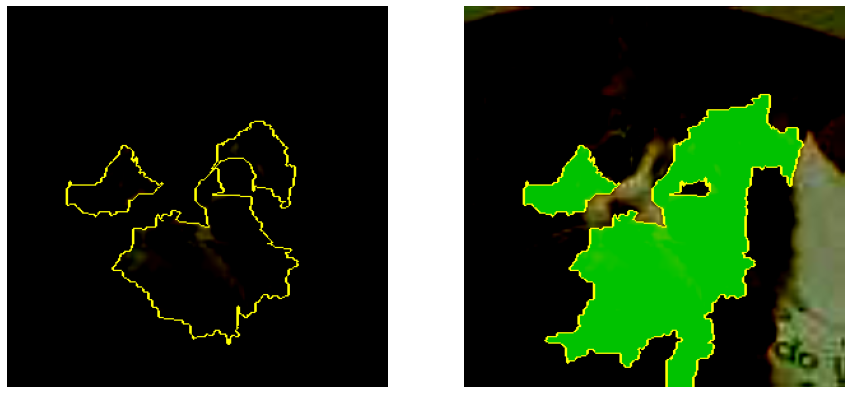

In [28]:
explanation= explainer.explain_instance(images_inc_im[0].astype('double'), inet_model.predict,  top_labels=2, hide_color=0, num_samples=1000)
 
temp_1, mask_1 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
temp_2, mask_2 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))
ax1.imshow(mark_boundaries(temp_1, mask_1))
ax2.imshow(mark_boundaries(temp_2, mask_2))
ax1.axis('off')
ax2.axis('off')